
# Introduction

In [18]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib import rcParams, font_manager
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [19]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/NMS_Copy_080125.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()

df_2 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/NMS_Copy_080125.xlsx', sheet_name='Final_compiled')

df_2_copy = df_2.copy()

# remove rows where Sample Type == 'Rain' in df_2_copy
df_2_copy = df_2_copy[df_2_copy['Sample type'] != 'Rain']

In [20]:
df_rain = df[df['Sample type'] == 'Rain']  

df_copy = df_copy[df_copy['Sample type'].isin(['Spring', 'Spring water', 'Groundwater'])] 

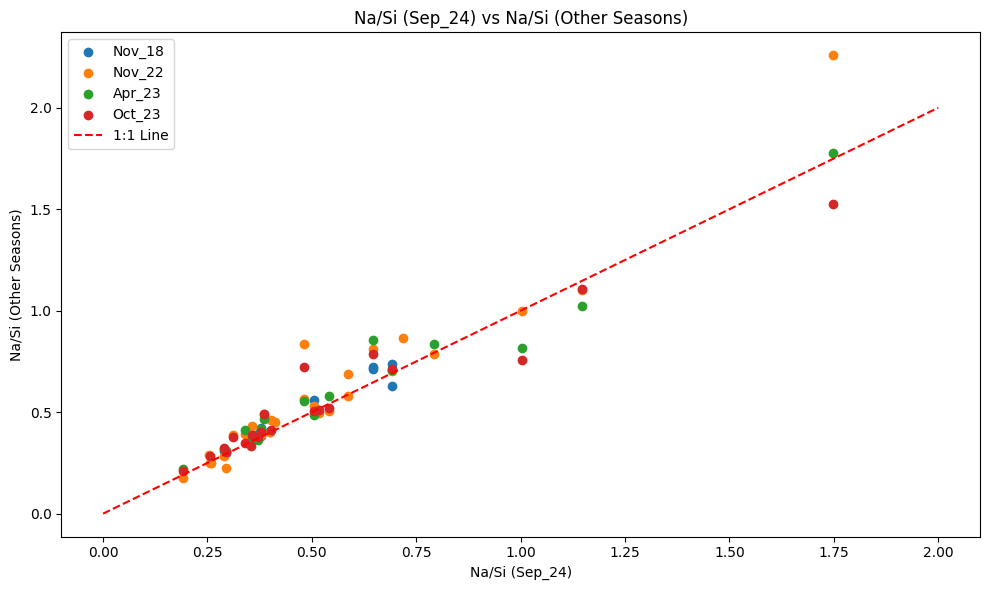

In [24]:

# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000
df_copy['Na/Si'] = df_copy['Na_mM'] / df_copy['Si_mM']
import re
import matplotlib.pyplot as plt

# Extract the part of GNS up to the second lot of numbers
def extract_gns_key(gns):
    if isinstance(gns, str):  # Ensure gns is a string
        match = re.match(r'(\D+\d+\D+)', gns)
        return match.group(0) if match else None
    return None  # Return None for non-string values

# Create a new column in the dataframe for the GNS key
df_copy['GNS_key'] = df_copy['GNS'].apply(extract_gns_key)

# Filter the data for Sep_24 and other seasons
df_sep_24 = df_copy[df_copy['Season'] == 'Sep_24']
df_other_seasons = df_copy[df_copy['Season'].isin(['Nov_18', 'Nov_22', 'Apr_23', 'Oct_23'])]

# Merge the dataframes on the GNS_key to match locations
merged_df = df_other_seasons.merge(df_sep_24[['GNS_key', 'Na/Si']], on='GNS_key', suffixes=('', '_Sep_24'))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each season's Na/Si against Sep_24's Na/Si
for season in ['Nov_18', 'Nov_22', 'Apr_23', 'Oct_23']:
    season_data = merged_df[merged_df['Season'] == season]
    ax.scatter(season_data['Na/Si_Sep_24'], season_data['Na/Si'], label=season)
    
# add a 1:1 line
ax.plot([0, 2], [0, 2], color='red', linestyle='--', label='1:1 Line')

# Set labels and title
ax.set_xlabel('Na/Si (Sep_24)')
ax.set_ylabel('Na/Si (Other Seasons)')
ax.set_title('Na/Si (Sep_24) vs Na/Si (Other Seasons)')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()




In [7]:

# # Path to the "Regular" style of CMU Typewriter Text
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Regular style
cmvtt_font = font_manager.FontProperties(fname=font_path)

# Set the font globally
rcParams['font.family'] = cmvtt_font.get_name()


In [8]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']

In [9]:
# remove NaN and non-numeric values from df_2_copy for the ions:
df_2_copy = df_2_copy.dropna(subset=['Ca_ppm', 'Sr_ppm', 'Mg_ppm', 'Si_ppm', 'Na_ppm', 'Li_ppm', 'K_ppm', 'Al_ppm', 'Cl_molar'])
# remove cells that have non-numeric values
df_2_copy = df_2_copy[df_2_copy['Ca_ppm'] != 'ND']


df_2_copy['Ca_mM'] = df_2_copy['Ca_ppm'] / 40.08
df_2_copy['Sr_mM'] = df_2_copy['Sr_ppm'] / 87.62
df_2_copy['Mg_mM'] = df_2_copy['Mg_ppm'] / 24.31
df_2_copy['Si_mM'] = df_2_copy['Si_ppm'] / 28.09
df_2_copy['Na_mM'] = df_2_copy['Na_ppm'] / 22.99
df_2_copy['Li_mM'] = df_2_copy['Li_ppm'] / 6.94
df_2_copy['K_mM'] = df_2_copy['K_ppm'] / 39.10
df_2_copy['Al_mM'] = df_2_copy['Al_ppm'] / 26.98

df_2_copy['Cl_mM'] = df_2_copy['Cl_molar'] / 1000

df_2_copy['Na/Ca'] = df_2_copy['Na_mM'] / df_2_copy['Ca_mM']
df_2_copy['Ca/Na'] = df_2_copy['Ca_mM'] / df_2_copy['Na_mM']
df_2_copy['Mg/Ca'] = df_2_copy['Mg_mM'] / df_2_copy['Ca_mM']
df_2_copy['Mg/Na'] = df_2_copy['Mg_mM'] / df_2_copy['Na_mM']
df_2_copy['Ca/Sr'] = df_2_copy['Ca_mM'] / df_2_copy['Sr_mM']
df_2_copy['1000xSr/Ca'] = df_2_copy['Sr_mM'] / df_2_copy['Ca_mM'] * 1000
df_2_copy['Si/Ca'] = df_2_copy['Si_mM'] / df_2_copy['Ca_mM']


In [10]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)

df_2_copy["Traverse"] = df_2_copy["GNS"].apply(assign_traverse)


In [ ]:
season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

traverse_markers = {
    'Traverse 1': 's',  # Square
    'Traverse 2': 'v',  # Triangle
    'Traverse 3': '*',  # Star
    'Traverse 3*' : '*',  # Star
    'Traverse 4': 'o',   # Circle
    'Traverse 5': 'D',   # Diamond
    'Traverse 5*': 'D'   # Diamond
}


tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 3*', 'Traverse 4', 'Traverse 5', 'Traverse 5*']


GNS_markers = {
    'S1': 'o',  
    'S2': 'o',  
    'S3': 'o',  
    'S4': 'o'   
}




# Making the DEM


In [12]:
## ADDING DEM DATA TO THE PLOT
    
dem_path = '/Users/enrico/Desktop/Part III Project/DEM/AP_23217_PLR_F0550_RT1/AP_23217_PLR_F0550_RT1.dem.tif'

    
# Define UTM bounds for Nepal DEM
min_x, min_y, max_x, max_y = 346873.46875, 3078339.0, 362335.96875, 3115539.0


# Define UTM bounds for Nepal DEM
# Set CRS WKT strings
utm_45n_wkt = 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],' \
            'AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],' \
            'UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],' \
            'PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],' \
            'PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],' \
            'PARAMETER["false_easting",500000],PARAMETER["false_northing",0],' \
            'UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32645"]]'

wgs84_wkt = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563],' \
            'AUTHORITY["EPSG","6326"]],' \
            'PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],' \
            'AUTHORITY["EPSG","4326"]]'

In [13]:
# Open the DEM file and set CRS to UTM Zone 45N if undefined
with rasterio.open(dem_path) as dem_raster:
    src_crs = rasterio.crs.CRS.from_wkt(utm_45n_wkt)  # Using WKT for UTM Zone 45N
    dst_crs = rasterio.crs.CRS.from_wkt(wgs84_wkt)    # Using WKT for WGS84

    # Create a Shapely box with UTM bounds
    dem_box = box(min_x, min_y, max_x, max_y)

    # Mask DEM data to these bounds
    out_image, out_transform = mask(dem_raster, [dem_box], crop=True)
    clipped_dem_array = out_image[0]

    # Calculate transform and reproject to WGS84
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, clipped_dem_array.shape[1], clipped_dem_array.shape[0], *[min_x, min_y, max_x, max_y]
    )

    dst_array = np.zeros((height, width), dtype=np.float32)
    reproject(
        source=clipped_dem_array,
        destination=dst_array,
        src_transform=out_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

    dst_array[dst_array < 0] = np.nan  # Filter out elevation values below 0

# Define bounds in WGS84 (latitude/longitude) for plotting
bounds = (
    dst_transform.c,  # min longitude
    dst_transform.f + dst_transform.e * height,  # min latitude
    dst_transform.c + dst_transform.a * width,  # max longitude
    dst_transform.f  # max latitude
)


In [14]:
# Generate the x and y coordinates in WGS84
x = np.linspace(bounds[0], bounds[2], dst_array.shape[1])
y = np.linspace(bounds[1], bounds[3], dst_array.shape[0])
x, y = np.meshgrid(x, y)
z = dst_array

# Interpolator for DEM elevations
interpolator = RegularGridInterpolator((y[:, 0], x[0, :]), z, bounds_error=False, fill_value=np.nan)

# Ensure the DataFrame coordinates are in the same CRS as the DEM
df_lons = df_copy['Longitude'].values
df_lats = df_copy['Latitude'].values

# Load the shapefile
shapefile_path1 = "/Users/enrico/Desktop/Part III Project/DEM/Clipped_Shp_Melamchi.shp"
gdf = gpd.read_file(shapefile_path1)



In [15]:
######### IMPORTING DATA FOR GEOLOGY OVERLAY #########

# Load the shapefile
shapefile_path2 = "/Users/enrico/Desktop/Part III Project/QGIS during Fieldwork/geometry5.shp"
gdf2 = gpd.read_file(shapefile_path2)

    

In [16]:
#For Shapefile
    # Define color mapping based on ID
id_to_color = {
    0: 'Blue',
    1: 'Green',
    2: 'Yellow',
    3: 'Orange',
    5: 'Purple',
    }

id_to_label = {
    0: 'Talamarang Formation',
    1: 'Gyalthum Formation',
    2: 'Bolde Quartzite',
    3: 'Timbung Formation',
    5: 'Golphu Formation',
    }

In [17]:
season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

traverse_markers = {
    'Traverse 1': 's',  # Square
    'Traverse 2': 'v',  # Triangle
    'Traverse 3': '*',  # Star
    'Traverse 3*' : '*',  # Star
    'Traverse 4': 'o',   # Circle
    'Traverse 5': 'D',   # Diamond
    'Traverse 5*': 'D'   # Diamond
}


tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 3*', 'Traverse 4', 'Traverse 5', 'Traverse 5*']


GNS_markers = {
    'S1': 'o',  
    'S2': 'o',  
    'S3': 'o',  
    'S4': 'o'   
}





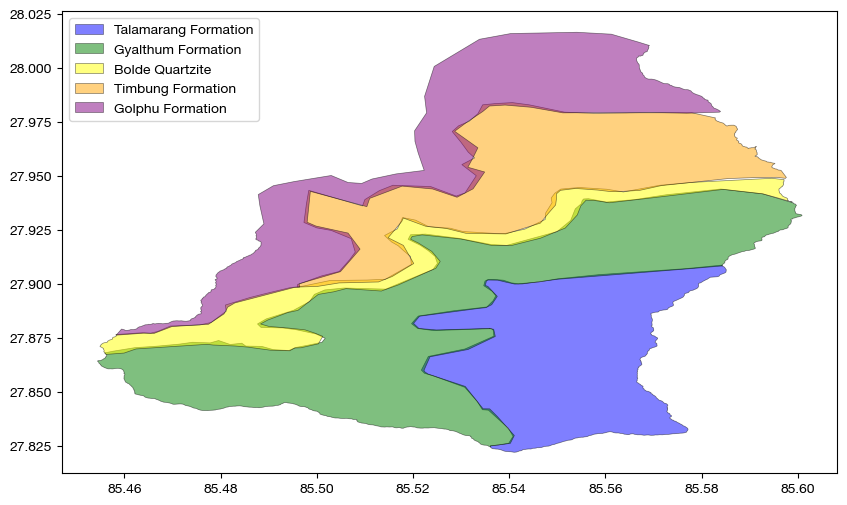

In [18]:
# Define the desired CRS, for example, "EPSG:4326" for WGS 84 or any other projection you need.
desired_crs = "EPSG:4326"

# Reproject the GeoDataFrame to the desired CRS
gdf2 = gdf2.to_crs(desired_crs)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the overlay shapefile with specified colors and labels
plotted_labels = set()  # Keeps track of which labels have been plotted
for geom, id_value in zip(gdf2.geometry, gdf2['id']):
    color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
    label = id_to_label.get(id_value, '')
    
    if isinstance(geom, Polygon):  # Check if geometry is a Polygon
        x_poly, y_poly = geom.exterior.xy  # Get exterior coordinates
        if label not in plotted_labels:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
            plotted_labels.add(label)
        else:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    elif isinstance(geom, MultiPolygon):  # Check if geometry is a MultiPolygon
        for part in geom.geoms:  # Iterate over constituent polygons
            x_poly, y_poly = part.exterior.xy
            if label not in plotted_labels:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
                plotted_labels.add(label)
            else:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)

# Add legend, title, etc., as needed
ax.legend()
plt.show()


# Multi Traverse Plot

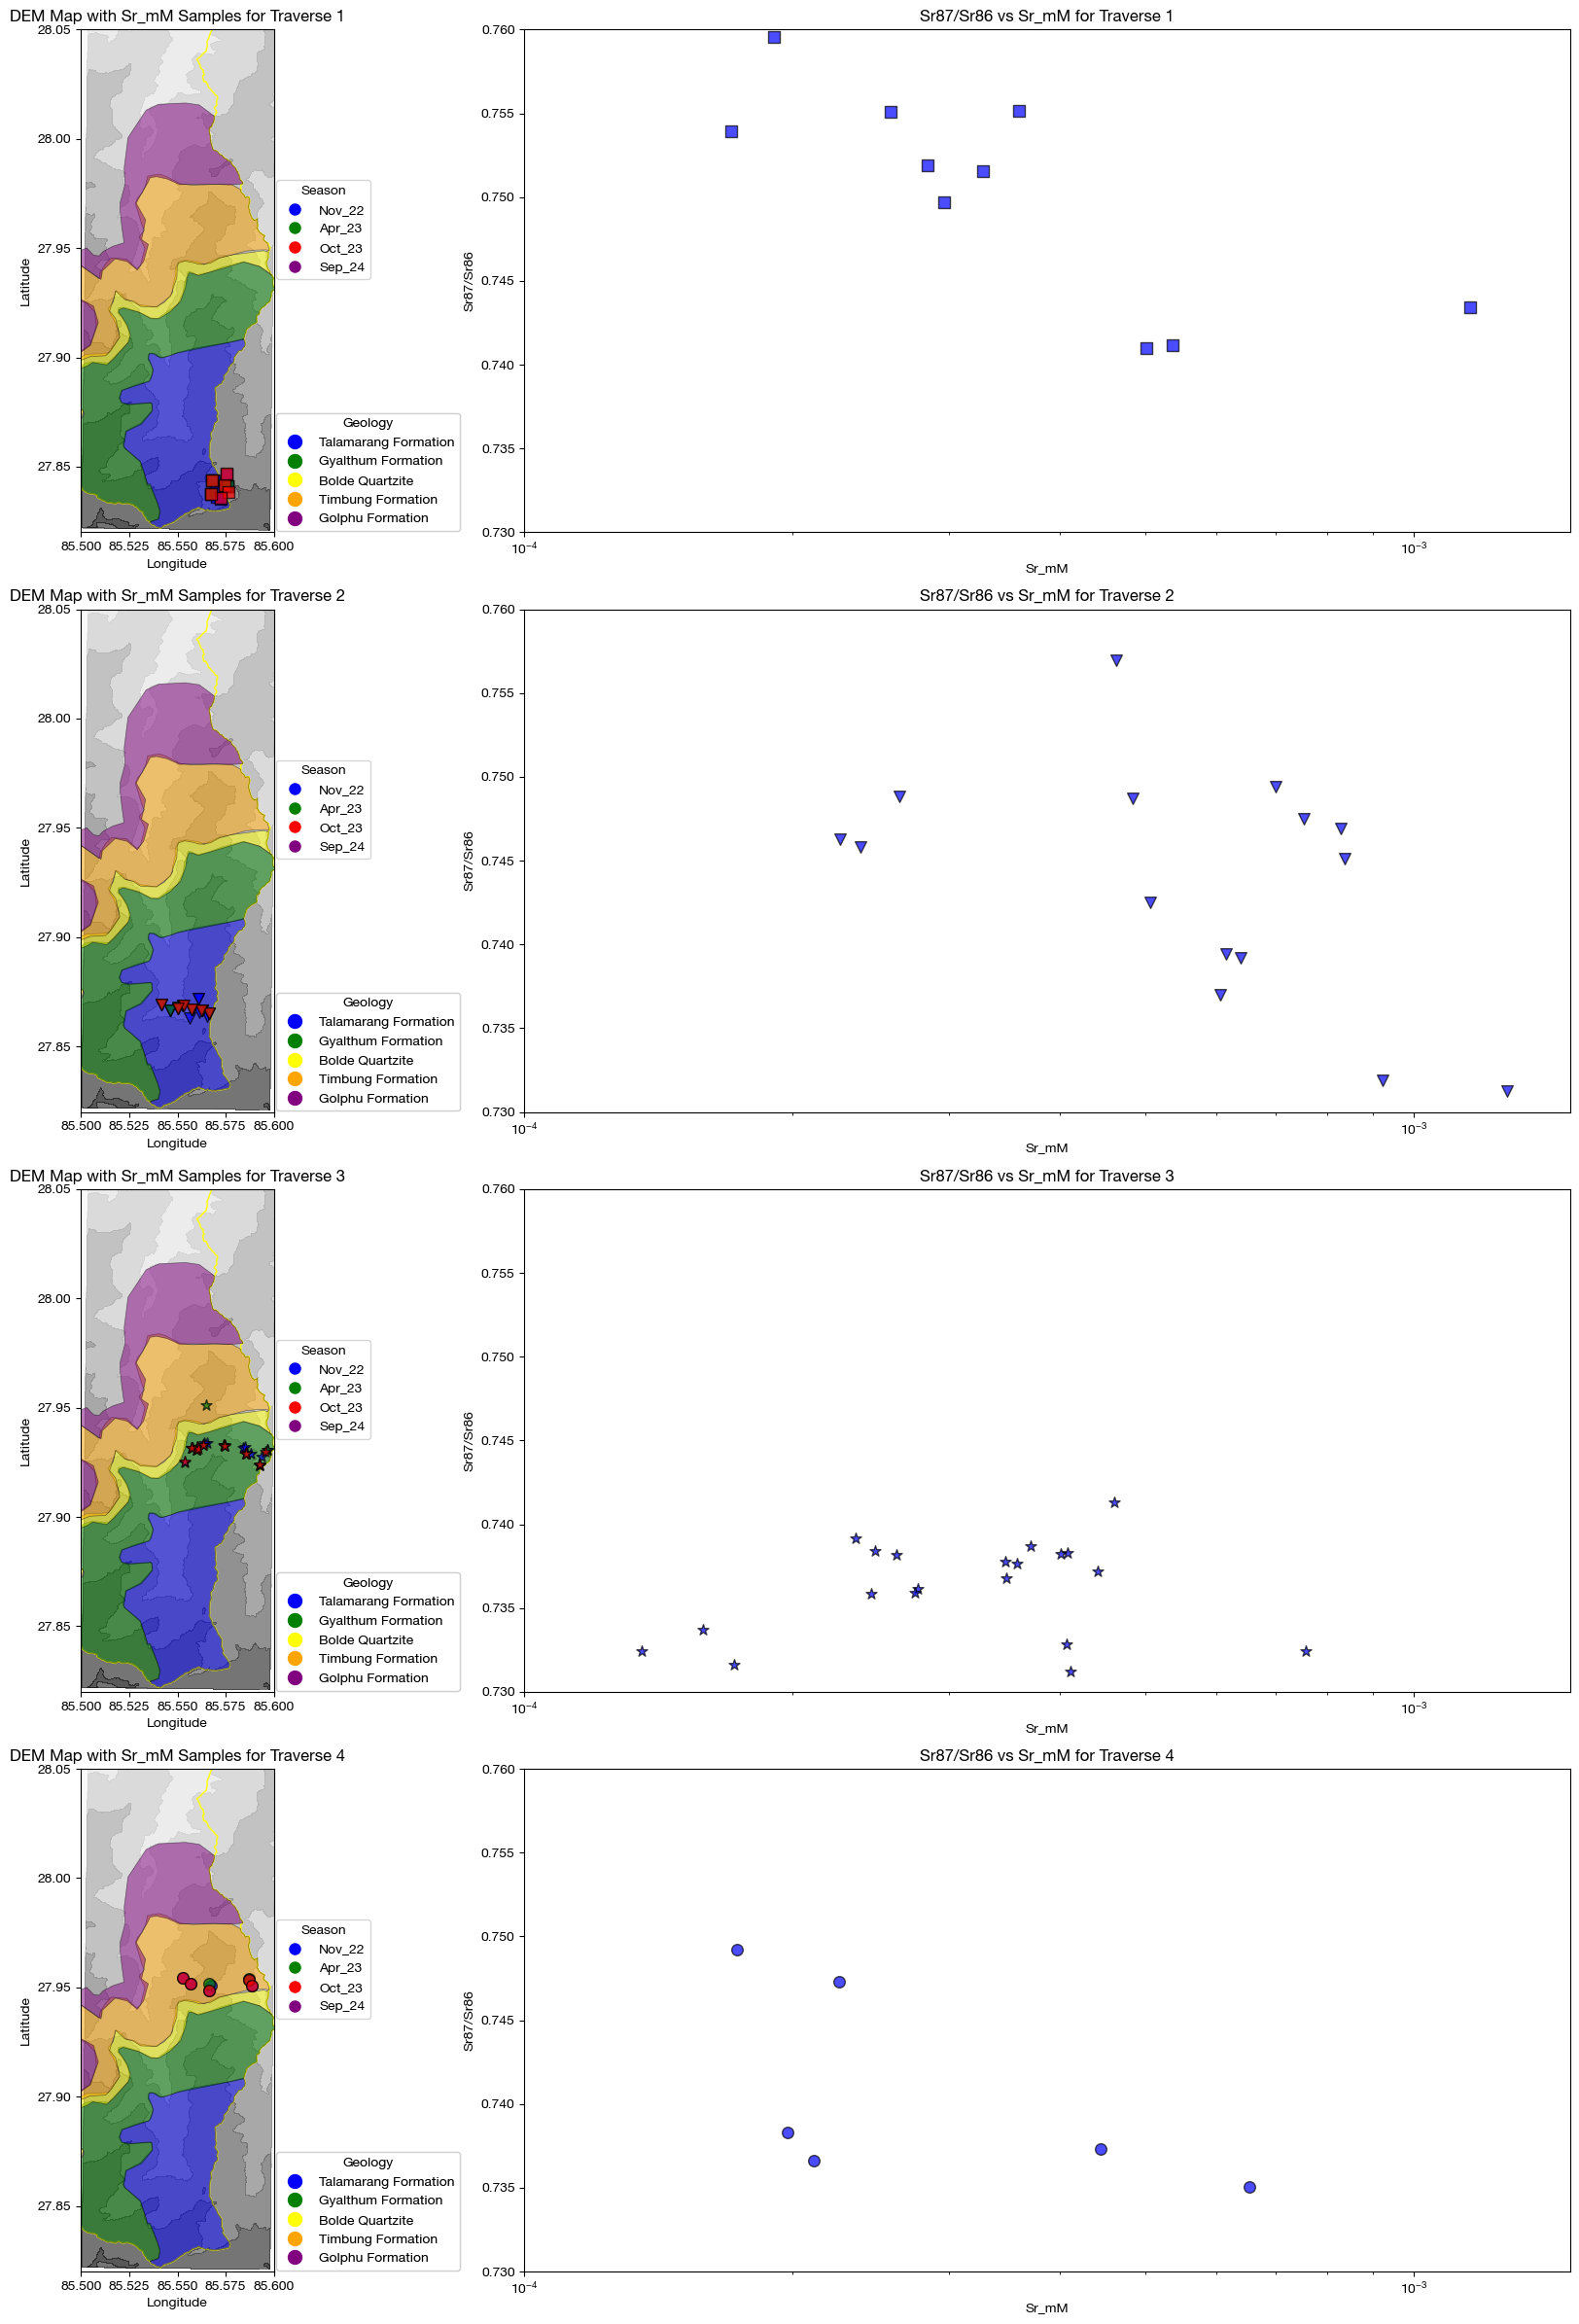

In [19]:
# Create the figure and axes for side-by-side plots
fig, axs = plt.subplots(4, 2, figsize=(20, 24))

# Define the variables and traverses
variables = ['Sr87/Sr86', 'Sr_mM']
tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4']

GNS_markers = ['S1', 'S2', 'S3', 'S4']


# Loop over each traverse and corresponding axes
for i, traverse in enumerate(tributaries):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    # Plot the DEM data in grayscale on ax1
    c = ax1.contourf(x, y, z, cmap='Greys', alpha=0.7)

    # Overlay the shapefile for watershed boundary
    gdf.plot(ax=ax1, facecolor='none', edgecolor='yellow', alpha=1, linewidth=1, label='Melamchi Watershed')
    
    # Overlay gdf2 on ax1 with specified colors and labels
    plotted_labels = set()  # Keeps track of which labels have been plotted
    geology_handles = []  # Handles for individual geology legend next to ax1
    for geom, id_value in zip(gdf2.geometry, gdf2['id']):
        color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
        label = id_to_label.get(id_value, '')
        
        if isinstance(geom, Polygon):
            x_poly, y_poly = geom.exterior.xy
            ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
            if label not in plotted_labels:
                plotted_labels.add(label)
                geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))
        elif isinstance(geom, MultiPolygon):
            for part in geom.geoms:
                x_poly, y_poly = part.exterior.xy
                ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
                if label not in plotted_labels:
                    plotted_labels.add(label)
                    geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))


    season_colors = {
        'Nov_22': 'blue',
        'Apr_23': 'green',
        'Oct_23': 'red',
        'Sep_24': 'purple'
    }

    # Plot the points for each season and traverse
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax1.scatter(
            season_data['Longitude'], season_data['Latitude'], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=traverse_markers[traverse], label=f'{traverse} - {season}'
        )


    # Create a legend for the seasons in ax1
    season_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=season) 
        for season, color in season_colors.items()
    ]

    # Set map limits for ax1
    ax1.set_xlim(85.5, 85.6)
    ax1.set_ylim(27.82, 28.05)


    # Labels and title for ax1
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'DEM Map with {variables[1]} Samples for {traverse}')
    season_legend = ax1.legend(handles=season_handles, title='Season', loc='upper left', bbox_to_anchor=(1.01, 0.7),
        borderaxespad=0.)

    # Place the geology legend to the right of ax1
    geology_legend = ax1.legend(
        handles=geology_handles, 
        title='Geology', 
        loc='center left', 
        bbox_to_anchor=(1.01, 0.12),
        borderaxespad=0.
    )

    # Add both legends to the plot
    ax1.add_artist(geology_legend)
    ax1.add_artist(season_legend)
    
    # Plotting data in ax2 (variable vs. elevation)
    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax2.scatter(
            season_data[variables[1]], season_data[variables[0]], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=traverse_markers[traverse], label=f'{traverse} - {season}'
        )

    ax2.set_xlabel(f'{variables[1]}')
    ax2.set_ylabel(f'{variables[0]}')
    ax2.set_xscale('log')
    ax2.set_ylim(0.73,0.76)
    ax2.set_xlim(0.0001,0.0015)
    ax2.set_title(f'{variables[0]} vs {variables[1]} for {traverse}')

# Adjust layout and save    
plt.tight_layout()
plt.savefig('Srisotopes-Sr.png', bbox_inches='tight')
plt.show()
plt.close(fig)

# Various ion plots

In [20]:
# consider a subset of df_2_copy whereby the Sample ID starts with "MKS":
df_2_copy_abra = df_2_copy[df_2_copy['Sample ID'].str.startswith('MKS')]

# df_abra has columns Ca_molar, Sr_molar, Na_molar, Cl_molar, K_molar, Mg_molar, Si_molar. 
# these are in micromolar units. To compare them we need to convert them to mM.

df_abra['Ca_mM'] = df_abra['Ca_molar'] / 1000
df_abra['Sr_mM'] = df_abra['Sr_molar'] / 1000000
df_abra['Na_mM'] = df_abra['Na_molar'] / 1000
df_abra['Cl_mM'] = df_abra['Cl_molar'] / 1000
df_abra['K_mM'] = df_abra['K_molar'] / 1000
df_abra['Mg_mM'] = df_abra['Mg_molar'] / 1000
df_abra['Si_mM'] = df_abra['Si_molar'] / 1000


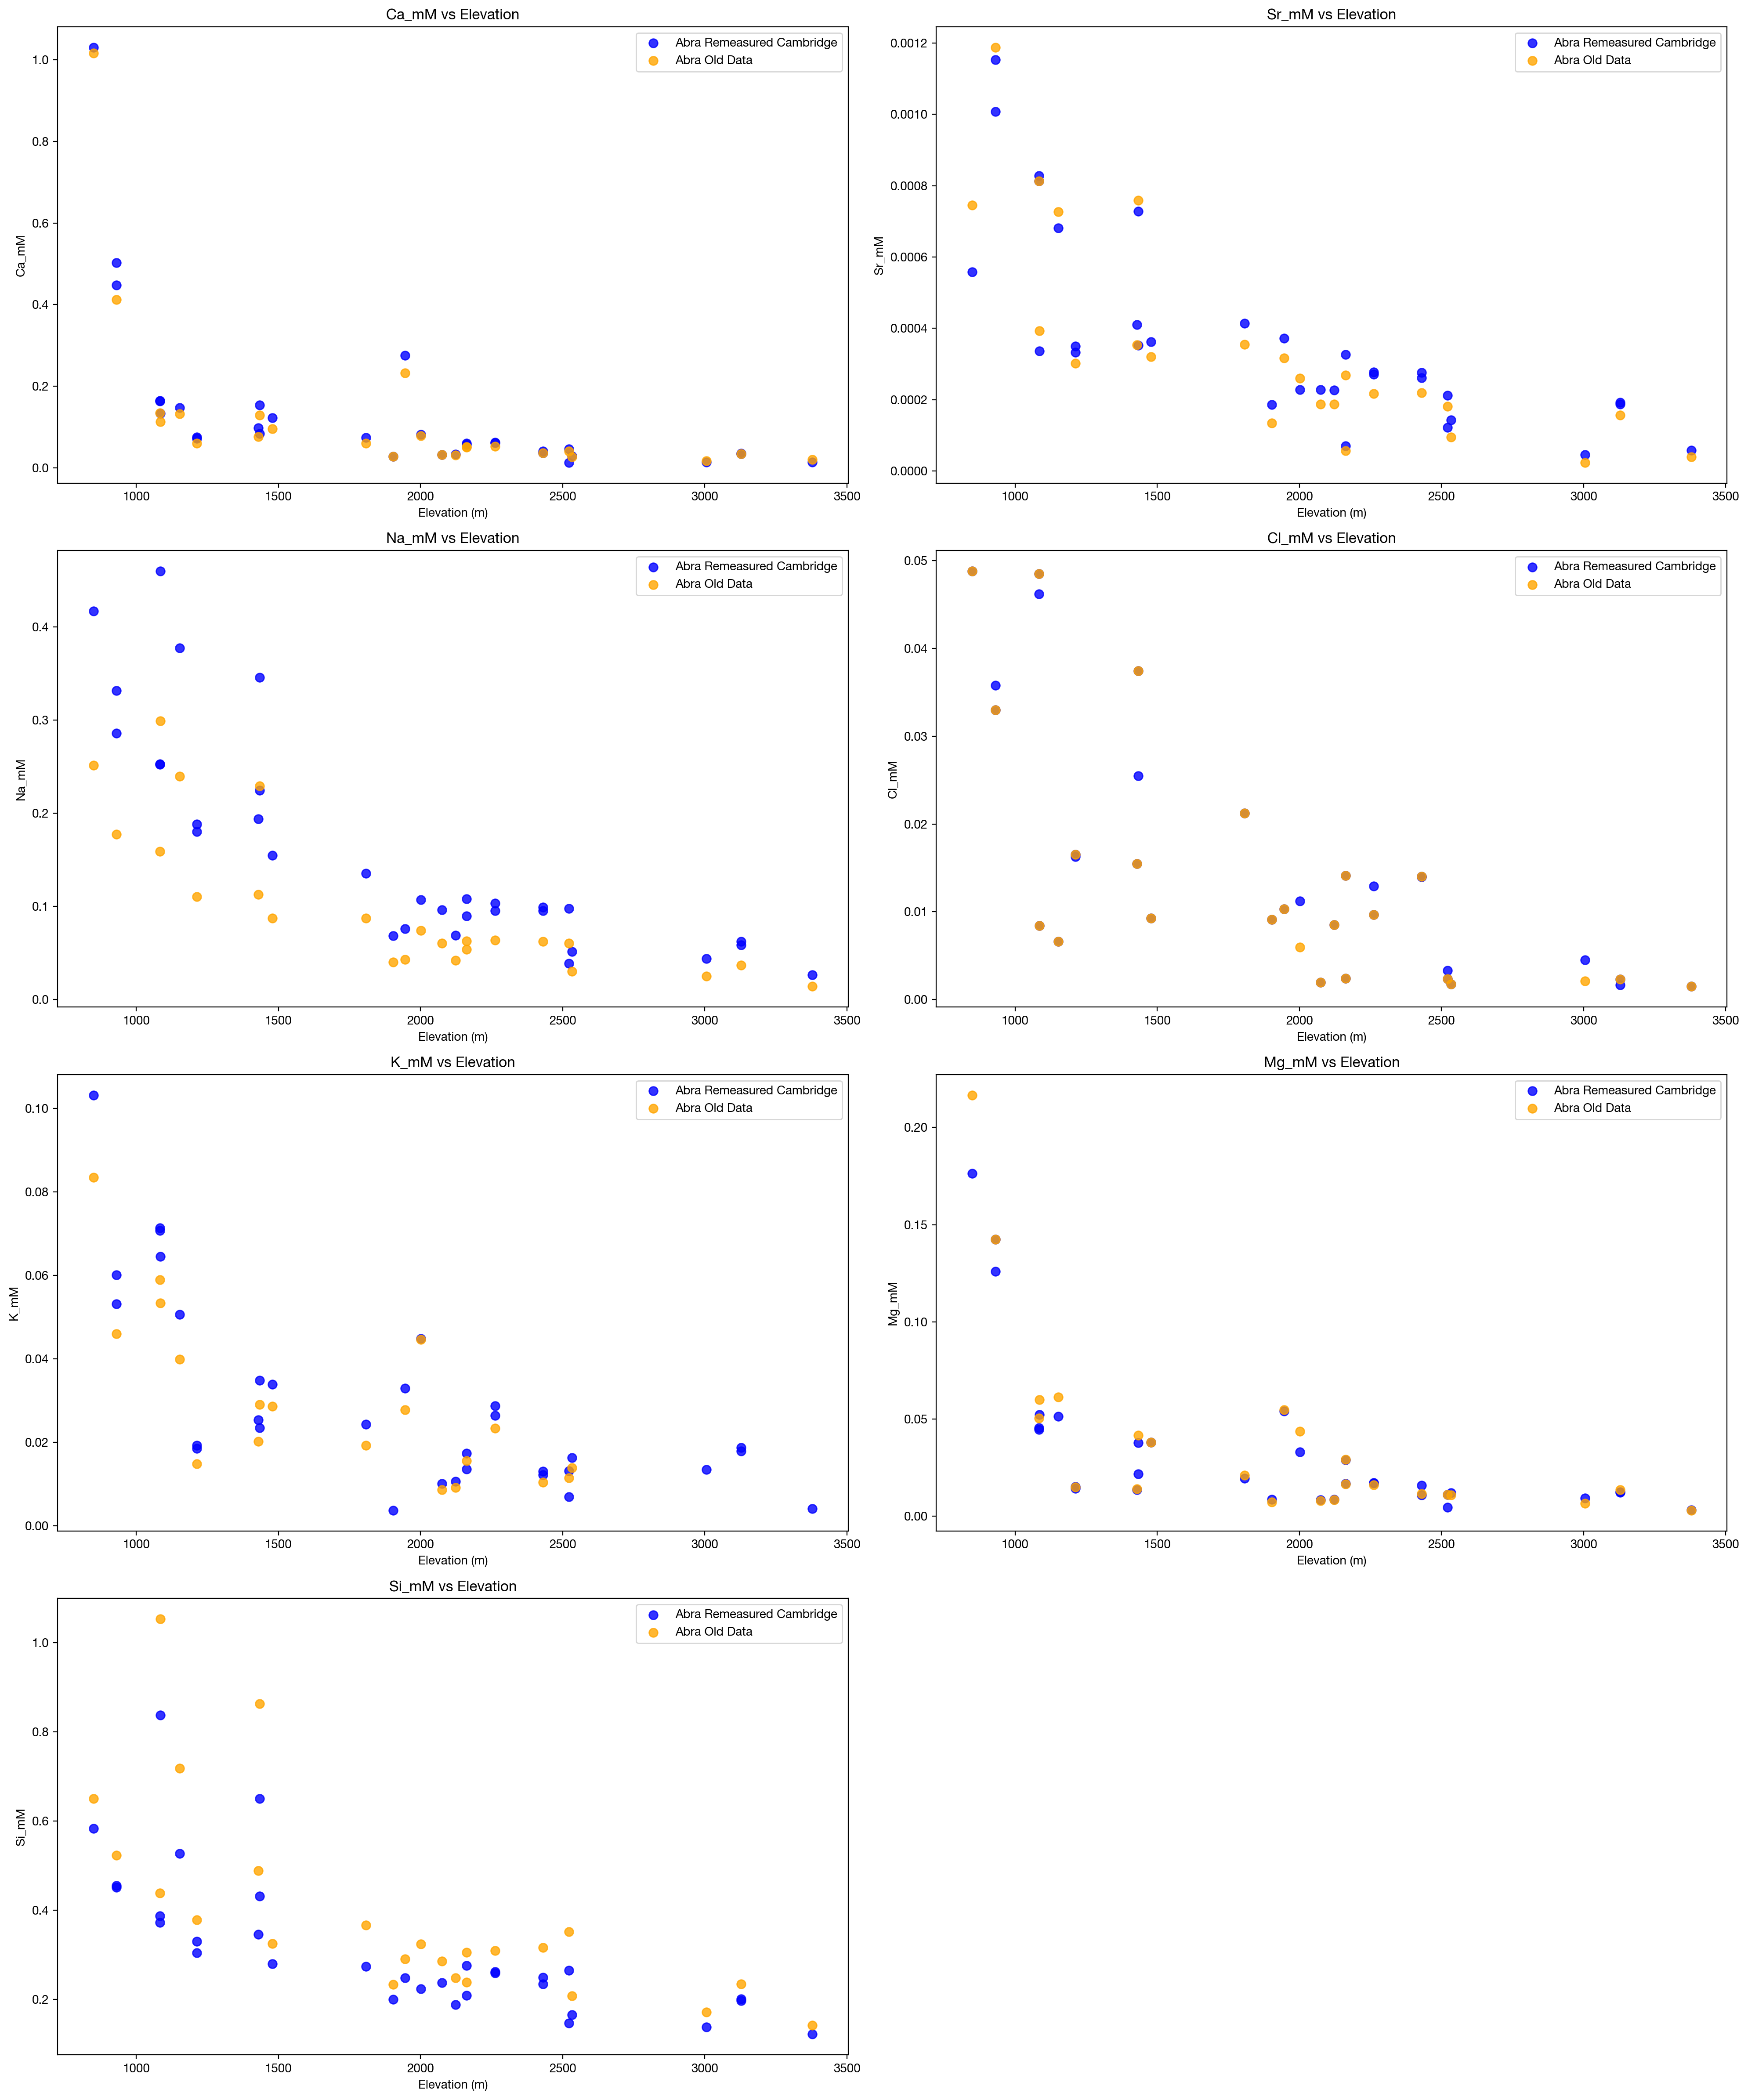

In [21]:

# Define the variables to plot
variables = ['Ca_mM', 'Sr_mM', 'Na_mM', 'Cl_mM', 'K_mM', 'Mg_mM', 'Si_mM']

# Create the figure and axes
fig, axs = plt.subplots(4, 2, figsize=(20, 24), dpi=200)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through each variable and plot
for i, var in enumerate(variables):
    ax = axs[i]
    # Plot data for df_2_copy_abra
    ax.scatter(df_2_copy_abra['Elevation'], df_2_copy_abra[var], label='Abra Remeasured Cambridge', color='blue', alpha=0.8, s=50)
    # Plot data for df_abra
    ax.scatter(df_abra['Elevation'], df_abra[var], label='Abra Old Data', color='orange', alpha=0.8, s=50)
    
    # Set labels and title
    ax.set_xlabel('Elevation (m)')
    ax.set_ylabel(var)
    ax.set_title(f'{var} vs Elevation')
    ax.legend()
    
# Hide the last subplot if the number of variables is less than the grid
if len(variables) < len(axs):
    axs[-1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


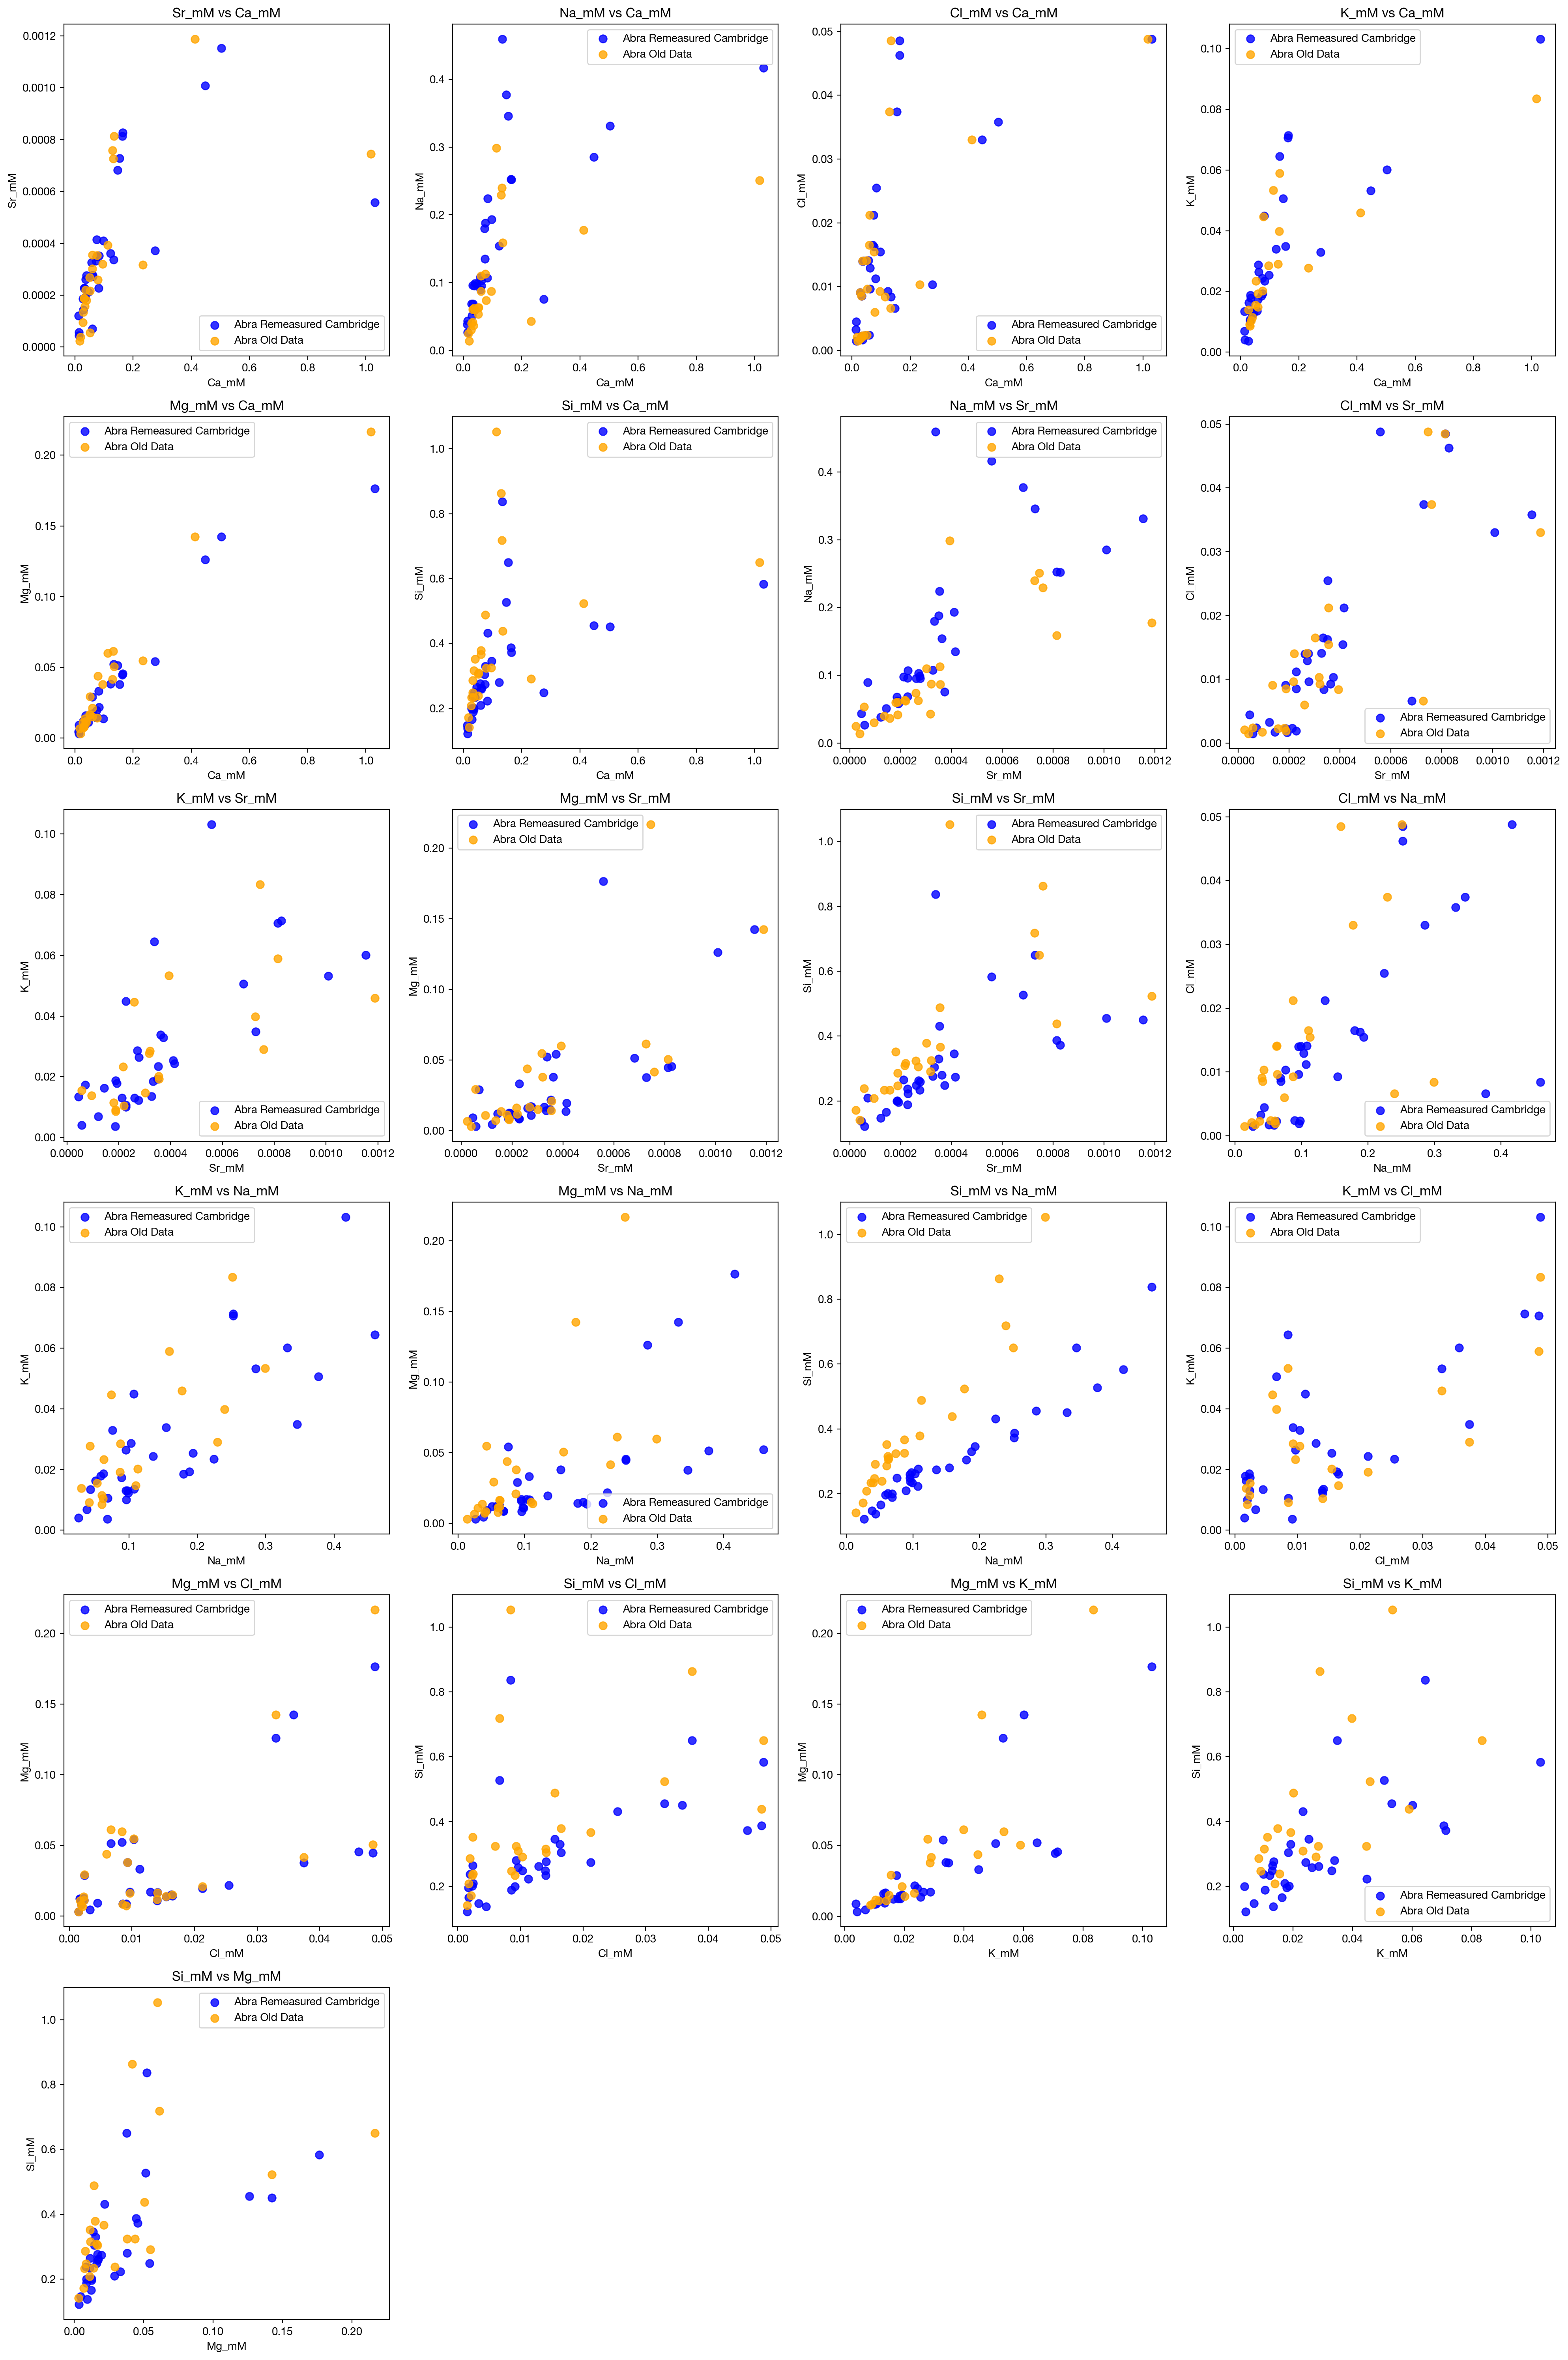

In [22]:
import itertools
import matplotlib.pyplot as plt

# Define the variables to cross-plot
variables = ['Ca_mM', 'Sr_mM', 'Na_mM', 'Cl_mM', 'K_mM', 'Mg_mM', 'Si_mM']

# Get all combinations of variables for crossplots
combinations = list(itertools.combinations(variables, 2))

# Calculate the number of rows and columns for subplots
n_combinations = len(combinations)
n_cols = 4
n_rows = (n_combinations + n_cols - 1) // n_cols

# Create the figure and axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), dpi=200)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through each combination and plot
for i, (var_x, var_y) in enumerate(combinations):
    ax = axs[i]
    # Plot data for df_2_copy_abra
    ax.scatter(df_2_copy_abra[var_x], df_2_copy_abra[var_y], label='Abra Remeasured Cambridge', color='blue', alpha=0.8, s=50)
    # Plot data for df_abra
    ax.scatter(df_abra[var_x], df_abra[var_y], label='Abra Old Data', color='orange', alpha=0.8, s=50)
    
    # Set labels and title
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.set_title(f'{var_y} vs {var_x}')
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


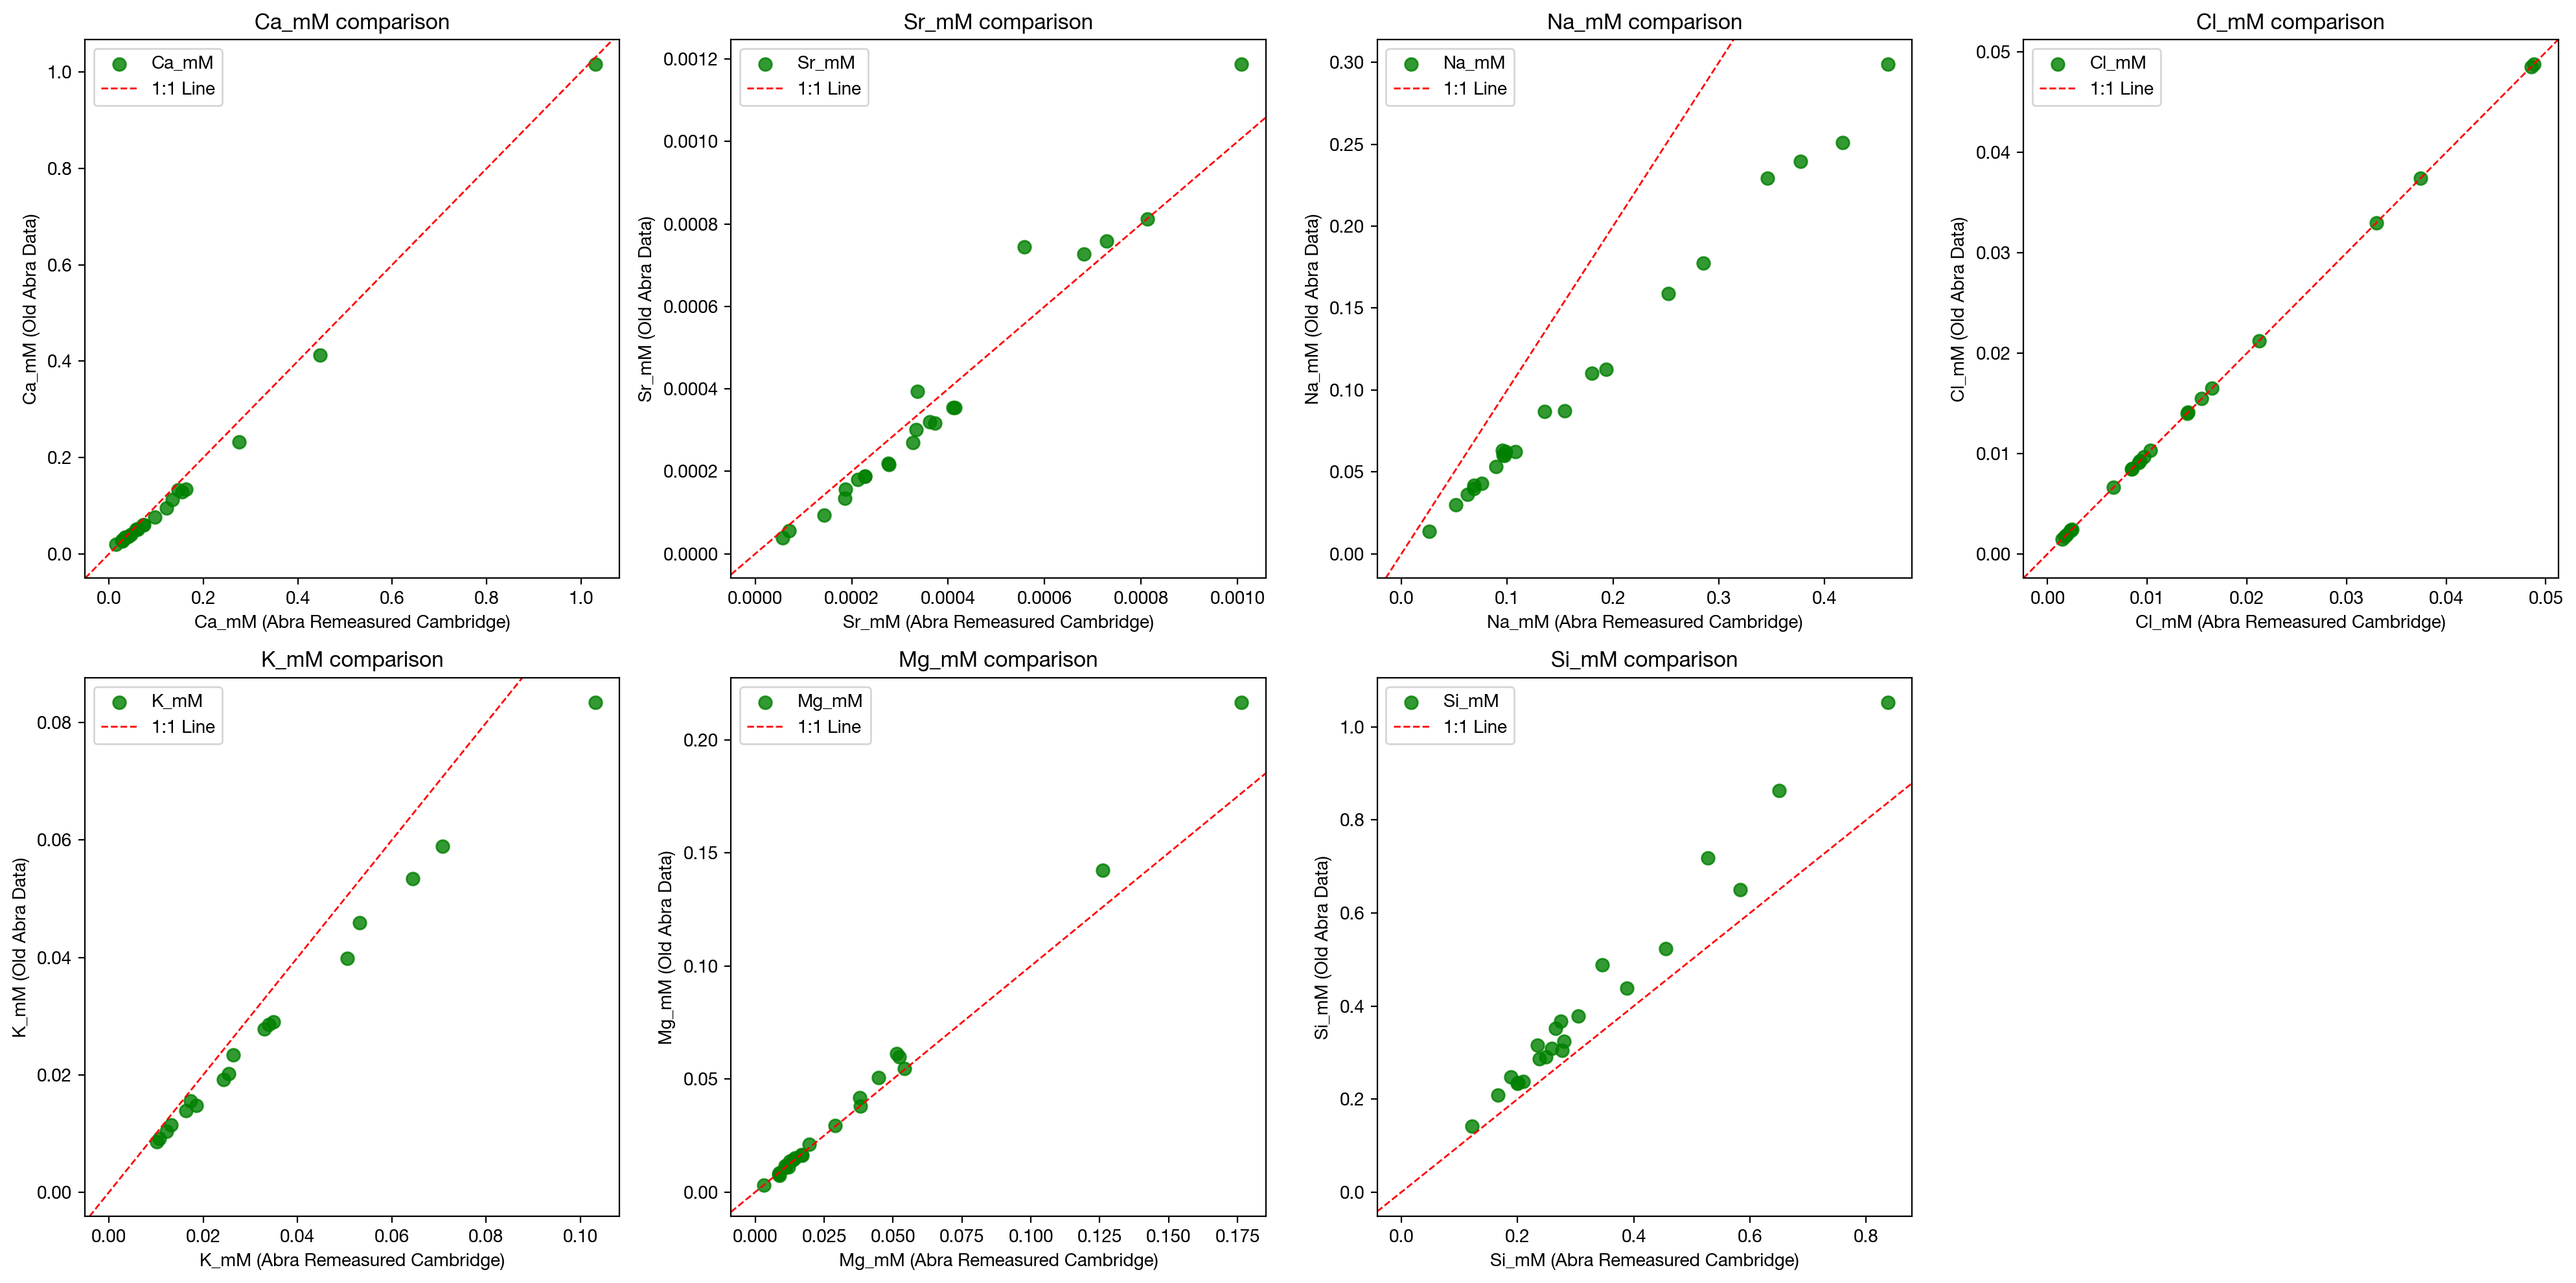

In [23]:
import matplotlib.pyplot as plt

# Define the variables to cross-plot
variables = ['Ca_mM', 'Sr_mM', 'Na_mM', 'Cl_mM', 'K_mM', 'Mg_mM', 'Si_mM']

# Merge the DataFrames based on the 'Sample' column
merged_df = pd.merge(
    df_2_copy_abra[['Sample ID'] + variables], 
    df_abra[['Sample ID'] + variables], 
    on='Sample ID', 
    suffixes=('_df2', '_df')
)

# Calculate the number of rows and columns for subplots
n_variables = len(variables)
n_cols = 4
n_rows = (n_variables + n_cols - 1) // n_cols

# Create the figure and axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), dpi=200)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through each variable and plot
for i, var in enumerate(variables):
    ax = axs[i]
    # Plot data: variable from df_2_copy_abra vs the same variable from df_abra
    ax.scatter(merged_df[f'{var}_df2'], merged_df[f'{var}_df'], label=f'{var}', color='green', alpha=0.8, s=50)
    
    # Set labels and title
    ax.set_xlabel(f'{var} (Abra Remeasured Cambridge)')
    ax.set_ylabel(f'{var} (Old Abra Data)')
    ax.set_title(f'{var} comparison')
    ax.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1, label='1:1 Line')  # Add 1:1 reference line
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


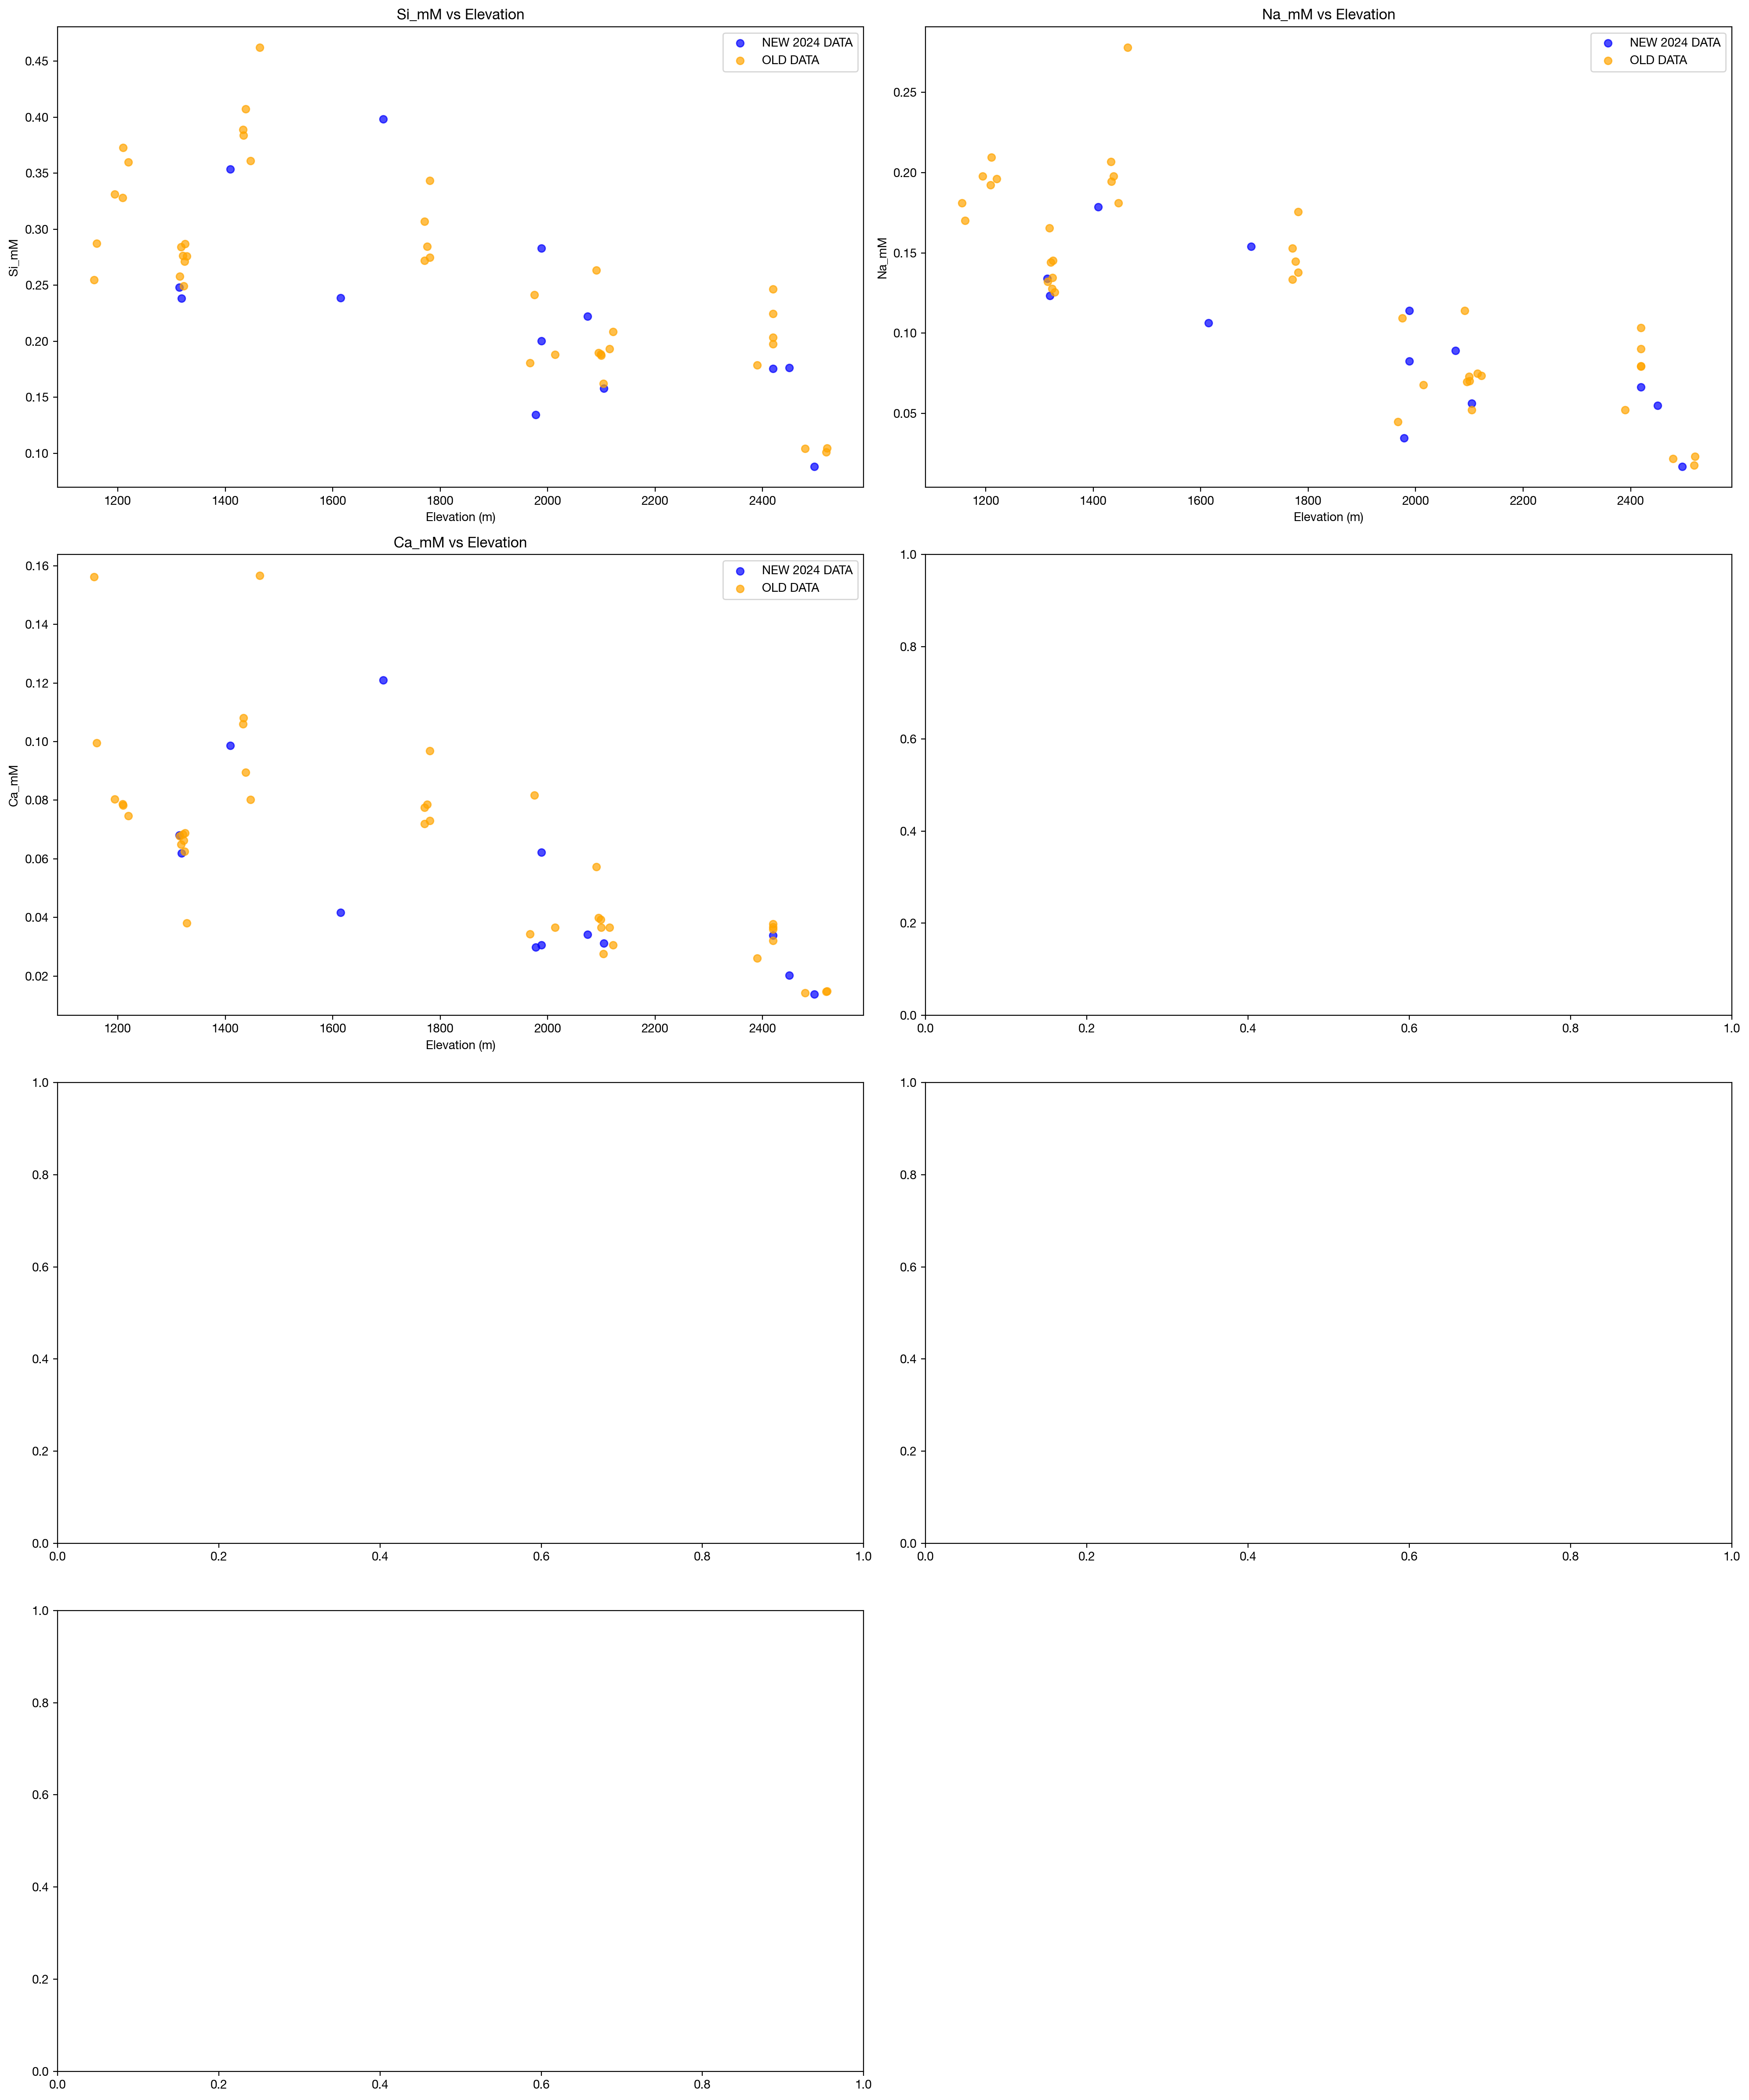

In [27]:
# now we want to compare df_2_copy samples that begin with NEP24 (irrespective of case for Nep or NEP) to df_copy samples that begin with NEP (irrespective of case)

# Filter DataFrames for the required samples
df_2_nep24 = df_2_copy[df_2_copy['Sample ID'].str.contains(r'^NEP24', case=False, na=False)]
df_nep = df_copy[df_copy['Sample ID'].str.contains(r'^NEP', case=False, na=False)]


df_nep_trav3 = df_nep[df_nep['Traverse'] == 'Traverse 3']
df_2_nep24_trav3 = df_2_nep24[df_2_nep24['Traverse'] == 'Traverse 3']




# Define the variables to plot
variables = ['Si_mM', 'Na_mM', 'Ca_mM']

# Create the figure and axes
fig, axs = plt.subplots(4, 2, figsize=(20, 24), dpi = 200)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through each variable and plot
for i, var in enumerate(variables):
    ax = axs[i]
    # Plot data for df_2_nep24
    ax.scatter(df_2_nep24_trav3['Elevation'], df_2_nep24_trav3[var], label='NEW 2024 DATA', color='blue', alpha=0.7)
    # Plot data for df_nep
    ax.scatter(df_nep_trav3['Elevation'], df_nep_trav3[var], label='OLD DATA', color='orange', alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel('Elevation (m)')
    ax.set_ylabel(var)
    ax.set_title(f'{var} vs Elevation')
    ax.legend()
    
# Hide the last subplot if the number of variables is less than the grid
if len(variables) < len(axs):
    axs[-1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


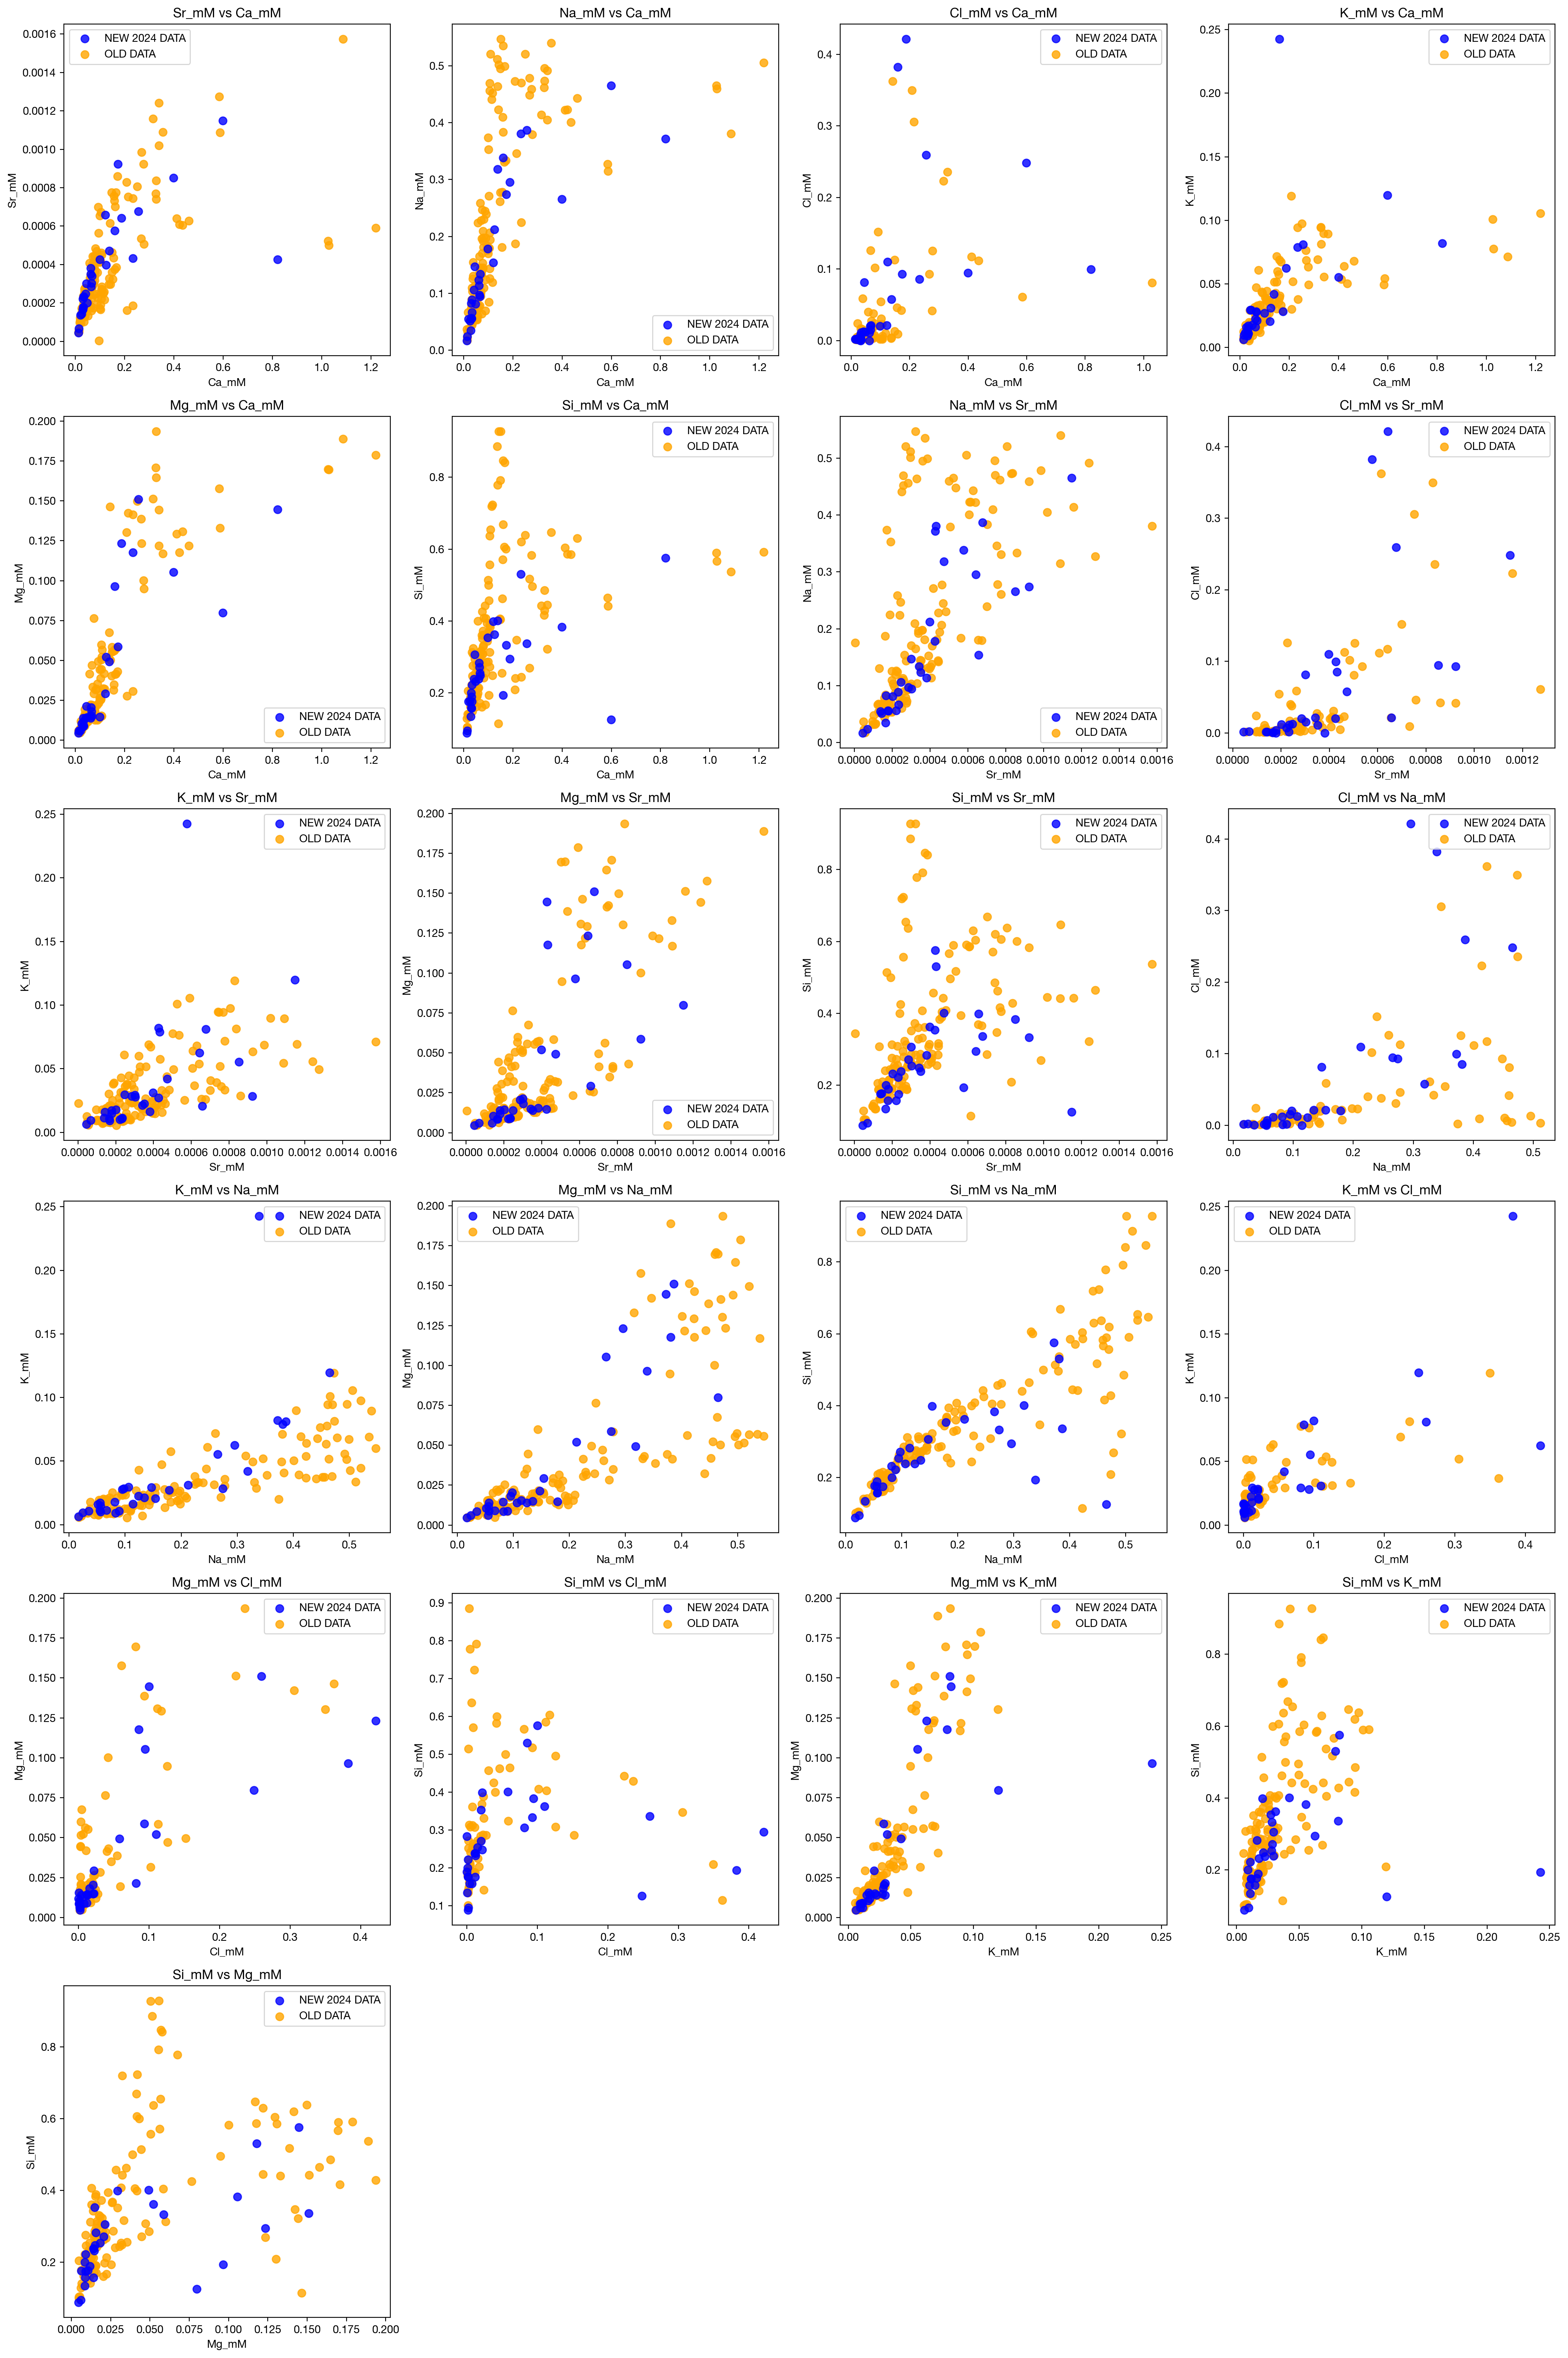

In [25]:
import itertools
import matplotlib.pyplot as plt

# Define the variables to cross-plot
variables = ['Ca_mM', 'Sr_mM', 'Na_mM', 'Cl_mM', 'K_mM', 'Mg_mM', 'Si_mM']

# Get all combinations of variables for crossplots
combinations = list(itertools.combinations(variables, 2))

# Calculate the number of rows and columns for subplots
n_combinations = len(combinations)
n_cols = 4
n_rows = (n_combinations + n_cols - 1) // n_cols

# Create the figure and axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), dpi=200)

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through each combination and plot
for i, (var_x, var_y) in enumerate(combinations):
    ax = axs[i]
    # Plot data for df_2_copy_abra
    ax.scatter(df_2_nep24[var_x], df_2_nep24[var_y], label='NEW 2024 DATA', color='blue', alpha=0.8, s=50, zorder = 3)
    # Plot data for df_abra
    ax.scatter(df_nep[var_x], df_nep[var_y], label='OLD DATA', color='orange', alpha=0.8, s=50, zorder = 2)
    
    # Set labels and title
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.set_title(f'{var_y} vs {var_x}')
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


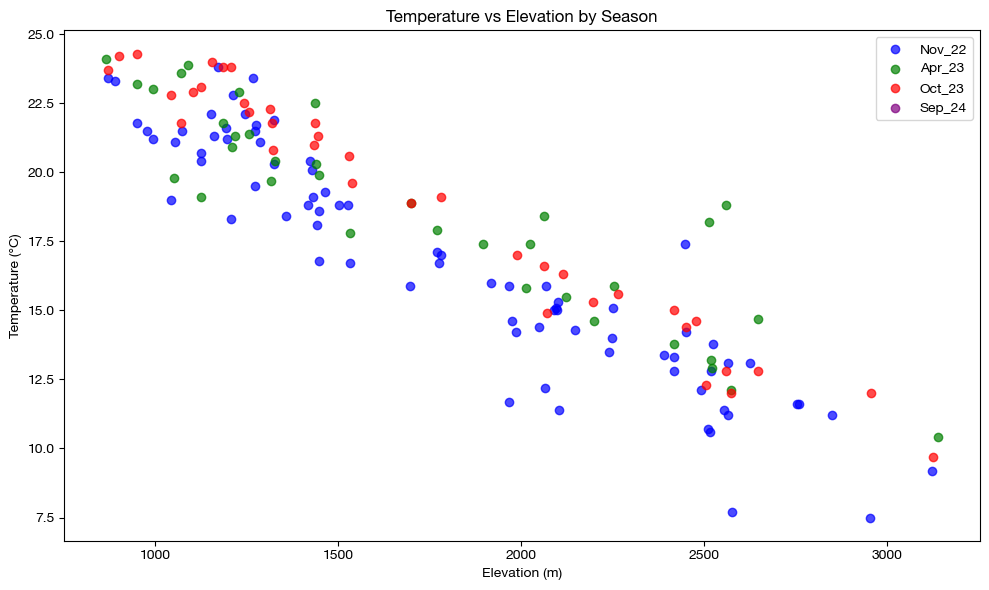

In [26]:
# plot temperature against elevation:

# Plot temperature against elevation colored by season
fig, ax = plt.subplots(figsize=(10, 6))

# Define the colors for each season
season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

# Plot the data
for season, color in season_colors.items():
    season_data = df_copy[df_copy['Season'] == season]
    ax.scatter(season_data['Elevation'], season_data['Temperature'], label=season, color=color, alpha=0.7)

# Set labels and title
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature vs Elevation by Season')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()